In [22]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import json
import random
from tempfile import TemporaryFile

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def get_data(num_training = 1845, num_validation = 200, num_test = 200):
    ''' 
    load the training data provided by Jake 
    
    '''
    # load the data
    x_total = np.load("data_5_frame_more_data.npy")
    y_total = np.load("label_5_frame_more_data.npy")
    train_index = np.load("train_index_1_frame.npy") 
    valid_index = np.load("valid_index_1_frame.npy")
    test_index = np.load("test_index_1_frame.npy")
    
    split_index = 50
    train_index = np.concatenate((train_index,valid_index[split_index:num_validation]))
    train_index = np.concatenate((train_index,test_index[split_index:num_test]))
    valid_index = valid_index[0:split_index]
    test_index = test_index[0:split_index]
    
    for each_valid_index in valid_index:
        remove_index = np.where((train_index/5).astype(int) == (each_valid_index/5).astype(int))
        train_index = np.delete(train_index, remove_index)
    
    for each_test_index in test_index:
        remove_index = np.where((train_index/5).astype(int) == (each_test_index/5).astype(int))
        train_index = np.delete(train_index, remove_index)
    
    # training data
    x_train = x_total[train_index]
    y_train = y_total[train_index]
    # validation data
    x_val = x_total[valid_index]
    y_val = y_total[valid_index]
    # test data
    x_test = x_total[test_index]
    y_test = y_total[test_index]
    
    # normalize the data: subtract the mean
    mean_video = np.floor(np.mean(x_train, axis=0))
    x_train = x_train - mean_video
    x_val = x_val - mean_video
    x_test = x_test - mean_video
    
    return x_train, y_train, x_val, y_val, x_test, y_test, mean_video

x_train, y_train, x_val, y_val, x_test, y_test, mean_video = get_data()

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (1780, 5, 224, 224, 3)
Train labels shape:  (1780,)
Validation data shape:  (50, 5, 224, 224, 3)
Validation labels shape:  (50,)
Test data shape:  (50, 5, 224, 224, 3)
Test labels shape:  (50,)


# plot salicency map

In [24]:
def compute_saliency_maps(sess, X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd((model.classifier),
                                  tf.stack((tf.range(int(X.shape[0]/5), dtype = 'int32'), tf.to_int32(model.labels)), axis=1)) # this returns the correct score
    ###############################################################################
    # TODO: Implement this function. You should use the correct_scores to compute #
    # the loss, and tf.gradients to compute the gradient of the loss with respect #
    # to the input image stored in model.image.                                   #
    # Use the global sess variable to finally run the computation.                #
    # Note: model.image and model.labels are placeholders and must be fed values  #
    # when you call sess.run().                                                   #
    ###############################################################################
    # dscore_img is loss w.r.t model.image: dscore_img is also a placeholder
    dscore_img = tf.gradients(correct_scores, model.image)
    # feed_dict is the data which X in input and y is output 
    feed_dict = {model.image: X, 
                 model.labels: y}
    # run the sessoin to get real dscore_img value
    sess.run(tf.global_variables_initializer())
    dscore_img_val = sess.run(dscore_img, feed_dict=feed_dict)[0]
    
    # take the absolute value
    dscore_img_val = abs(dscore_img_val) 
    
    # take the max over three channels
    saliency = np.max(dscore_img_val, axis = 3) 
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency



In [40]:
def show_saliency_maps(sess, model, X, y):
    
    N,F,H,W,C = X.shape
    X_reshape = np.reshape(X, [N*F,H,W,C])
    print (X_reshape.shape)
    print (y.shape)
    Xm = X_reshape[155:160]
    N = Xm.shape[0]
    ym = y[31:32]
    saliency = compute_saliency_maps(sess, Xm, ym, model) # shape of 1*F*H*W*1
    print (saliency.shape)
    
    for i in range(N):
        print (i)
        plt.subplot(2, N, i + 1)
        plt.imshow((Xm[i]+mean_video[0]))
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.title(i+1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

# load the model for saliency map for 5 frame

In [41]:
def my_model(rg, lr, dr, dc, FC_size):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
    model = SqueezeNet(save_path=SAVE_PATH, sess=sess)
    regularizers = 0
    NUM_CLASSES = 4 
    with tf.variable_scope('classifier_squeeze_frame'):
        with tf.variable_scope('layer0'):
            FRAME_PER_VIDEO = tf.constant(5, dtype='int32')
            x = model.features
            dims = tf.shape(x)
            N,H,W,C = dims[0], dims[1], dims[2], dims[3]
            x = tf.reshape(x, [tf.to_int32(N/FRAME_PER_VIDEO), H*W*C*FRAME_PER_VIDEO]) 
            W1 = tf.get_variable("weights1",shape=[432640,FC_size])
            b1 = tf.get_variable("bias1",shape=[FC_size])
            x = tf.matmul(x,W1)+b1
            regularizers += tf.nn.l2_loss(W1)
            W2 = tf.get_variable("weights2",shape=[FC_size,NUM_CLASSES])
            b2 = tf.get_variable("bias2",shape=[NUM_CLASSES])
            x = tf.matmul(x,W2)+b2
            regularizers += tf.nn.l2_loss(W2)
    model.classifier = x 
    return sess, model

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


INFO:tensorflow:Restoring parameters from 5_frame_model.ckpt


INFO:tensorflow:Restoring parameters from 5_frame_model.ckpt


Model restored.
map
(250, 224, 224, 3)
(50,)
(5, 224, 224)
0
1
2
3
4


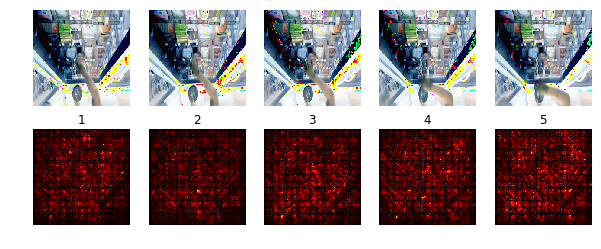

In [42]:
with tf.device("/gpu:0") as dev:
    # for 5 frame
    rg = 0.027082
    lr = 0.000042
    dr = 0.891485 
    dc = 986
    FC_size = 100         
    sess, model = my_model(rg, lr, dr, dc, FC_size)
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    # Restore variables from disk.
    saver.restore(sess, "5_frame_model.ckpt")
    print("Model restored.")
    # comment out the saliceny map
    print('map')
    show_saliency_maps(sess,model,x_test, y_test)    